In [2]:
import numpy as np
import tensorflow as tfs
from util import ImShow as I
import matplotlib.pyplot as plt

http://kvfrans.com/variational-autoencoders-explained/

### implementation notes

* for last_dim, next_dim in zip(encode_dim, encode_dim[1:]): is very nice for iteration to get two terms at same time

  \[last_dim,next_dim  for last_dim, next_dim in zip(reversed(encode_dim), reversed(encode_dim[:-1]))\]
  
  

* Argue: should the encoder and decoder share bias term?
    - no, since they have different dimension
    - yes, since $f^{-1}$ should be exactly same with $f$

In [3]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
num_steps = 50000

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [4]:
encode_dim = [784,512]
input_dim = encode_dim[0]
latent_dim = 2
num = 64
learning_rate = 0.001
def init(shape,rtype='uniform'):
    if rtype == 'normal':
        return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))
    if rtype == 'uniform':
        if len(shape) == 2:
            init_max_value = np.sqrt(6. / (shape[0] + shape[1]))
            return tf.random_uniform(shape,np.negative(init_max_value),init_max_value)
        else:
            init_max_value = np.sqrt(6. / (shape[0]))
            return tf.random_uniform(shape,np.negative(init_max_value),init_max_value)
with tf.Graph().as_default():
    with tf.Session() as sess:
        input_x = tf.placeholder(dtype=tf.float32,shape=[num,input_dim])
        weight_list = []
        encode_bias_list = []
        decode_bias_list = []
        # init encoding weight,bias
        for last_dim, next_dim in zip(encode_dim, encode_dim[1:]):
            weight_list.append(tf.Variable(init([last_dim,next_dim])))
            encode_bias_list.append(tf.Variable(init([next_dim])))
        # init decoding bias
        for last_dim, next_dim in zip(reversed(encode_dim), reversed(encode_dim[:-1])):
            decode_bias_list.append(tf.Variable(init([next_dim])))
        hidden_mean_weight = tf.Variable(init([encode_dim[-1],latent_dim]))
        hidden_mean_bias = tf.Variable(init([latent_dim]))
        hidden_variance_weight = tf.Variable(init([encode_dim[-1],latent_dim]))
        hidden_variance_bias = tf.Variable(init([latent_dim]))
        decode_weight = tf.Variable(init([latent_dim,encode_dim[-1]]))
        decode_bias = tf.Variable(init([encode_dim[-1]]))
        # Building Graph
        # encoder
        hidden_layer = input_x
        for weight,bias in zip(weight_list,encode_bias_list):
            hidden_layer = tf.nn.sigmoid(tf.matmul(hidden_layer,weight) + bias)
        # representation trick
        mean = tf.matmul(hidden_layer, hidden_mean_weight) + hidden_mean_bias
        variance = tf.matmul(hidden_layer, hidden_variance_weight) + hidden_variance_bias
        print variance.shape
        # sample from N(0,1)
        samples = tf.random_normal(tf.shape(variance),dtype=tf.float32,mean=0.0,stddev=1.0,name='samples')
        hidden_layer = mean + tf.exp(variance / 2) * samples
        hidden_layer = tf.nn.sigmoid(tf.matmul(hidden_layer,decode_weight) + decode_bias)
        # decoder
        for weight,bias in zip(reversed(weight_list),decode_bias_list):
            hidden_layer = tf.nn.sigmoid(tf.matmul(hidden_layer, tf.transpose(weight)) + bias)
        recon = hidden_layer
        # compute loss
        ## reconstruction loss
        recon_loss = (input_x * tf.log(1e-9 + recon)) + ((1- input_x) * tf.log(1e-9 + 1 - recon))
        recon_loss = - tf.reduce_sum( recon_loss, 1)
        ## close to gaussian loss
        gaussian_loss = -0.5 * tf.reduce_sum((1 + variance - tf.square(mean) - tf.exp(variance)),1)
        loss = tf.reduce_mean(recon_loss + gaussian_loss)
        
        optimizer = tf.train.RMSPropOptimizer(learning_rate = learning_rate)
        train_op = optimizer.minimize(loss)
        
        init = tf.global_variables_initializer()
        
        sess.run(init)
        # Training
        for i in range(1, num_steps+1):
            # Prepare Data
            # Get the next batch of MNIST data (only images are needed, not labels)
            batch_x, _ = mnist.train.next_batch(num)

            # Train
            feed_dict = {input_x: batch_x}
            _, l = sess.run([train_op, loss], feed_dict=feed_dict)
            if i % 1000 == 0 or i == 1:
                print('Step %i, Loss: %f' % (i, l))
                
                
        noise_input = tf.placeholder(tf.float32,shape=[None,latent_dim])
        hidden = tf.nn.sigmoid(tf.matmul(noise_input,decode_weight) + decode_bias)
        print "hidden",hidden.shape
        for weight,bias in zip(reversed(weight_list),decode_bias_list):
            hidden_layer = tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(weight)) + bias)
        out = hidden_layer
        noise = np.random.multivariate_normal(mean = [0.,0.], cov= np.eye(2), size = 100)
        x_mean = sess.run(out, feed_dict={noise_input: noise})

(64, 2)
Step 1, Loss: 562.823608
Step 1000, Loss: 184.374054
Step 2000, Loss: 180.014099
Step 3000, Loss: 193.692764
Step 4000, Loss: 176.910919
Step 5000, Loss: 165.523254
Step 6000, Loss: 160.043671
Step 7000, Loss: 161.019073
Step 8000, Loss: 160.663757
Step 9000, Loss: 154.185669
Step 10000, Loss: 170.620667
Step 11000, Loss: 166.265411
Step 12000, Loss: 162.169189
Step 13000, Loss: 167.079193
Step 14000, Loss: 149.210175
Step 15000, Loss: 152.689514
Step 16000, Loss: 150.721832
Step 17000, Loss: 152.385269
Step 18000, Loss: 148.687241
Step 19000, Loss: 158.232605
Step 20000, Loss: 154.735016
Step 21000, Loss: 162.446289
Step 22000, Loss: 152.621277
Step 23000, Loss: 151.068054
Step 24000, Loss: 155.271423
Step 25000, Loss: 161.323700
Step 26000, Loss: 161.125839
Step 27000, Loss: 155.711456
Step 28000, Loss: 150.659149
Step 29000, Loss: 154.242798
Step 30000, Loss: 153.375595
Step 31000, Loss: 161.590988
Step 32000, Loss: 146.181061
Step 33000, Loss: 141.060486
Step 34000, Loss: 1

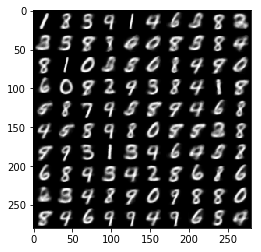

In [6]:
Xpic = I.tile_raster_images(X = x_mean, img_shape=(28,28), tile_shape=(10,10))
plt.imshow(Xpic,cmap='gray')
plt.show()

In [7]:
encode_dim = [784,400,200]
for last_dim, next_dim in zip(encode_dim, encode_dim[1:]):
    print last_dim,next_dim
print "-----------------------"
for last_dim, next_dim in zip(reversed(encode_dim), reversed(encode_dim[:-1])):
    print last_dim,next_dim

784 400
400 200
-----------------------
200 400
400 784
